<a href="https://colab.research.google.com/github/lamass/Biz_var_projects/blob/main/sp_returns_vis_MA_StationaryTest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!git clone https://github.com/EvilPsyCHo/Deep-Time-Series-Prediction.git

Cloning into 'Deep-Time-Series-Prediction'...
remote: Enumerating objects: 706, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 706 (delta 25), reused 20 (delta 20), pack-reused 662
Receiving objects: 100% (706/706), 4.66 MiB | 30.04 MiB/s, done.
Resolving deltas: 100% (341/341), done.


In [18]:
# encoding: utf-8
"""
@author : zhirui zhou
@contact: evilpsycho42@gmail.com
@time   : 2020/9/27 14:52
"""
import torch
import torch.nn as nn
# from deepseries.model.seq2seq.utils import *
# from deepseries.model.seq2seq.encoder import RNNEncoder
# from deepseries.model.seq2seq.decoder import AttnRNNDecoder
import random


In [14]:
# encoding: utf-8
"""
@author : zhirui zhou
@contact: evilpsycho42@gmail.com
@time   : 2020/9/27 14:51
"""
import torch
import torch.nn as nn


class RNNEncoder(nn.Module):

    def __init__(self, input_size, rnn_type, hidden_size, bidirectional, num_layers, dropout):
        super().__init__()
        self.input_size = input_size
        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.num_direction = 2 if self.bidirectional else 1
        self.input_dropout = nn.Dropout(dropout)
        self.rnn = getattr(nn, rnn_type)(input_size=input_size, bidirectional=bidirectional, batch_first=True,
                                         num_layers=num_layers, hidden_size=hidden_size, dropout=dropout)

    def forward(self, input: torch.Tensor):
        batch_size = input.shape[0]
        output, hidden = self.rnn(self.input_dropout(input))

        def _reshape_hidden(hn):
            hn = hn.view(self.num_layers, 2, batch_size, self.hidden_size). \
                permute(0, 2, 1, 3).reshape(self.num_layers, batch_size, self.num_direction * self.hidden_size)
            return hn

        if self.bidirectional and self.rnn_type != "LSTM":
            hidden = _reshape_hidden(hidden)
        elif self.bidirectional and self.rnn_type == "LSTM":
            h, c = _reshape_hidden(hidden[0]), _reshape_hidden(hidden[1])
            hidden = (h, c)

        return output, hidden


In [13]:
# encoding: utf-8
"""
@author : zhirui zhou
@contact: evilpsycho42@gmail.com
@time   : 2020/9/27 15:04
"""
import torch
import torch.nn as nn


class MultiEmbeddings(nn.Module):

    def __init__(self, *variable_params):
        # example: *[(name, num_embeddings, embedding_dim), ... ]
        super().__init__()
        self.params = variable_params
        self.embeddings = nn.ModuleDict({
            name: nn.Embedding(s, e) for (name, s, e) in variable_params
        })

    def forward(self, input):
        return torch.cat([self.embeddings[name](input[name]) for (name, _, _) in self.params], dim=2)


class Empty(nn.Module):

    def __init__(self, size):
        self.size = size
        super().__init__()

    def forward(self, x):
        return x

    def extra_repr(self):
        return f"{self.size}"


class Inputs(nn.Module):

    def __init__(self, inputs_config=None):
        super().__init__()
        self.inputs_config = inputs_config
        if inputs_config is not None:
            self.numerical = inputs_config.get("numerical")
            self.categorical = inputs_config.get("categorical")
            self.output_size = 0
            if self.categorical is not None:
                self.categorical_inputs = MultiEmbeddings(*self.categorical)
                self.output_size += sum([i[2] for i in self.categorical])

            if self.numerical is not None:
                self.numerical_inputs = nn.ModuleDict({name: Empty(size) for (name, size) in self.numerical})
                self.output_size += sum([i[1] for i in self.numerical])
        else:
            self.output_size = 0

    def forward(self, feed_dict):
        # batch, seq, N
        if self.inputs_config is not None:
            outputs = []
            if self.categorical is not None:
                outputs.append(self.categorical_inputs(feed_dict))
            if self.numerical is not None:
                for (name, _) in self.numerical:
                    outputs.append(self.numerical_inputs[name](feed_dict[name]))
            return torch.cat(outputs, dim=2)
        else:
            return None


In [16]:
# encoding: utf-8
"""
@author : zhirui zhou
@contact: evilpsycho42@gmail.com
@time   : 2020/9/27 14:51
"""
import torch
import torch.nn as nn
# from deepseries.nn import Attention


class RNNDecoder:

    pass


class AttnRNNDecoder(nn.Module):

    def __init__(self, input_size, output_size, rnn_type, hidden_size,
                 num_layers, dropout, attn_head, attn_size, activation="ReLU", residual=False):
        super().__init__()
        self.input_size = input_size
        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.residual = residual

        self.input_dropout = nn.Dropout(dropout)
        self.rnn = getattr(nn, rnn_type)(input_size=input_size, batch_first=True,
                                         num_layers=num_layers, hidden_size=hidden_size, dropout=dropout)
        self.attention = Attention(attn_head, attn_size, hidden_size, hidden_size, hidden_size, dropout)
        self.activation = getattr(nn, activation)()
        regression_input_size = attn_size + hidden_size
        if residual:
            regression_input_size += input_size
        self.regression = nn.Linear(regression_input_size, output_size)

    def forward(self, input: torch.Tensor, hidden: torch.Tensor, encoder_output):
        # step input -> (batch, seq, N); previous dec hidden (layer, batch, hidden_size)
        dec_rnn_output, dec_rnn_hidden = self.rnn(input, hidden)
        # attention
        attn_applied, attn_weights = self.attention(dec_rnn_output, encoder_output, encoder_output)
        # predict
        if self.residual:
            concat = self.activation(torch.cat([attn_applied, dec_rnn_output, input], dim=2))
        else:
            concat = self.activation(torch.cat([attn_applied, dec_rnn_output], dim=2))
        output = self.regression(concat)
        return output, hidden, attn_weights


In [17]:
# encoding: utf-8
"""
@author : zhirui zhou
@contact: evilpsycho42@gmail.com
@time   : 2020/5/7 9:22
"""
import torch.nn as nn
import torch.nn.functional as F
import torch
import math


class Align(nn.Module):
    """
    Compute 'Scaled Dot Product Attention

    References:
        https://github.com/codertimo/BERT-pytorch/blob/d10dc4f9d5a6f2ca74380f62039526eb7277c671/bert_pytorch/model/attention/single.py#L8
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class Attention(nn.Module):
    """
    Take in model size and number of heads.
    general attention

    Args:
        query, key, value, mask. shape like (B, S, N)
    Returns:
        attention_value, (B, query_lens, N)
        attention_weight, (B, Head, query_lens, values_lens)
    References:
        https://github.com/codertimo/BERT-pytorch/blob/d10dc4f9d5a6f2ca74380f62039526eb7277c671/bert_pytorch/model/attention/single.py#L8
    """
    def __init__(self, heads, attn_size, query_size, key_size, value_size, dropout):
        super().__init__()
        assert attn_size % heads == 0

        # We assume d_v always equals d_k
        self.d_k = attn_size // heads
        self.h = heads

        self.linear_layers = nn.ModuleList([nn.Linear(s, attn_size) for s in [query_size, key_size, value_size]])
        self.output_linear = nn.Linear(attn_size, attn_size)
        self.align = Align()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """inputs shape (B, S, N)"""

        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.align(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        # (B, S, N), (B, H, S_q, S_k)
        return self.output_linear(x), attn


if __name__ == "__main__":

    q = torch.rand(4, 7, 30)
    k = torch.rand(4, 12, 9)

    attn = Attention(heads=3, attn_size=9, query_size=30, value_size=9, key_size=9, dropout=0.)
    values, weights = attn(q, k, k)


In [25]:
SP500_values.tail(9)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change
Date,,,,,,,,
2023-02-21 00:00:00-05:00,4052.350098,4052.350098,3995.189941,3997.340088,4121590000,0.0,0.0,-0.020041
2023-02-22 00:00:00-05:00,4001.830078,4017.370117,3976.899902,3991.050049,4079320000,0.0,0.0,-0.001574
2023-02-23 00:00:00-05:00,4018.600098,4028.300049,3969.189941,4012.320068,3952940000,0.0,0.0,0.005329
2023-02-24 00:00:00-05:00,3973.239990,3978.250000,3943.080078,3970.040039,3877700000,0.0,0.0,-0.010538
2023-02-27 00:00:00-05:00,3992.360107,4018.050049,3973.550049,3982.239990,3836950000,0.0,0.0,0.003073
2023-02-28 00:00:00-05:00,3977.189941,3997.500000,3968.979980,3970.149902,5043400000,0.0,0.0,-0.003036
2023-03-01 00:00:00-05:00,3963.340088,3971.729980,3939.050049,3951.389893,4249480000,0.0,0.0,-0.004725
2023-03-02 00:00:00-05:00,3938.679932,3990.840088,3928.159912,3981.350098,4244900000,0.0,0.0,0.007582
2023-03-03 00:00:00-05:00,3998.020020,4048.290039,3995.169922,4045.639893,4084730000,0.0,0.0,0.016148


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.9 MB/s eta 0:00:00


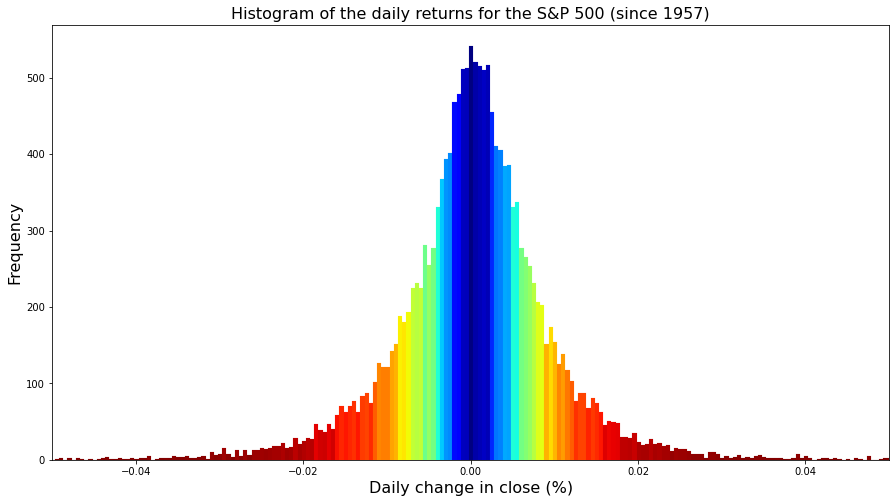

In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# for the fitting
from scipy.optimize import curve_fit
from scipy.stats import levy_stable

# install and use the yfinance package, written by Ran Aroussi
# https://github.com/ranaroussi/yfinance
!pip -q install yfinance
import yfinance as yf

# the S&P 500 ticker symbol is GSPC
SP500 = yf.Ticker("^GSPC")
 
SP500_values = SP500.history(start="1957-03-04")

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html
SP500_values['pct_change'] = SP500_values.Close.pct_change(periods = 1)

# now produce the plot
plt.figure(figsize = (15,8))
ax = sns.histplot(SP500_values['pct_change'], binwidth=0.0005)
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet_r(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.title("Histogram of the daily returns for the S&P 500 (since 1957)", size=16)
plt.xlabel("Daily change in close (%)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xlim(-0.05, 0.05);

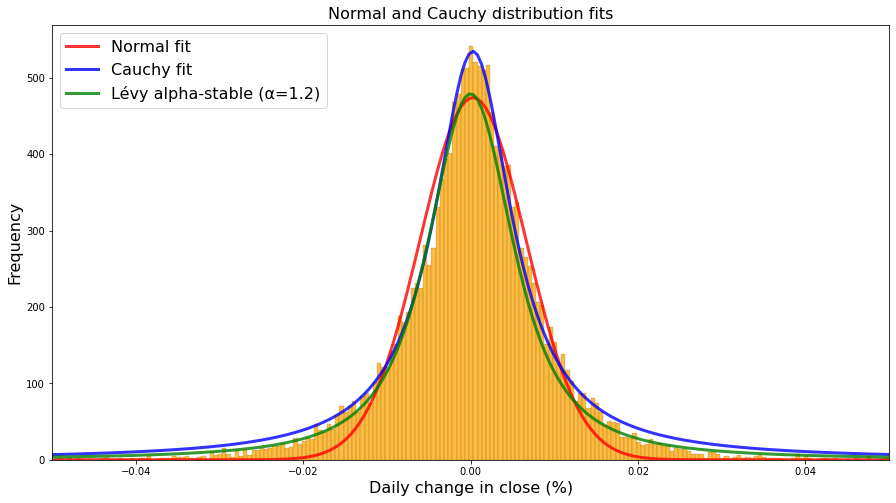

In [24]:
# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)
# define a Lorentzian function
def Lorentzian(x, x0, gamma, A):
    return A * gamma**2/(gamma**2+( x - x0 )**2)

n_values = values.shape[0]
xmin = SP500_values['pct_change'].min()
xmax = SP500_values['pct_change'].max()
delta = xmax-xmin
x = np.arange(xmin, xmax, (delta/n_values))
y = values

# seed guess
initial_guess=(0, 0.005, 300)

# the Gaussian fit
G_parameters,G_covariance=curve_fit(Gaussian,x,y,initial_guess)
G_sigma=np.sqrt(np.diag(G_covariance))

# the Lorentzian fit
L_parameters,L_covariance=curve_fit(Lorentzian,x,y,initial_guess)
L_sigma=np.sqrt(np.diag(L_covariance))

# and plot
plt.figure(figsize = (15,8))
ax = sns.histplot(SP500_values['pct_change'], binwidth=0.0005, color='orange')
ax = plt.plot(x,Gaussian(x,*G_parameters),  color='red', lw=3,label='Normal fit', alpha=0.8)
ax = plt.plot(x,Lorentzian(x,*L_parameters),color='blue',lw=3,label='Cauchy fit', alpha=0.8)
ax = plt.plot(x, levy_stable.pdf(x, 1.2, 0, 0, 1/200)*8,color='green',lw=3,label='Lévy alpha-stable (α=1.2)', alpha=0.8)
plt.title("Normal and Cauchy distribution fits", size=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Daily change in close (%)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xlim(-0.05, 0.05);

# Time series: A simple moving average (MA) model

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

!pip -q install yfinance
import yfinance as yf

In [27]:
IBEX = yf.Ticker("^IBEX")
# get historical market data
IBEX_values = IBEX.history(start="2020-06-01")

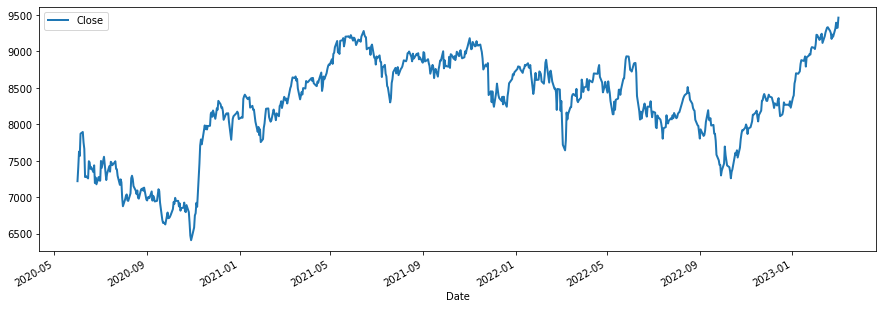

In [28]:
IBEX_values[['Close']].plot(lw=2);

## Moving average model
To create our moving average model we shall use ARIMA from statsmodels. This is a composite of an autoregressive model, AR( 𝑝
 ), an integration model, I( 𝑑
 ), and a moving average model, MA( 𝑞
 ), which is passed via the tuple order(p,d,q). Here we shall use again a window of  𝑞=10
 :

In [29]:
from statsmodels.tsa.arima.model import ARIMA
ARMA_model = ARIMA(endog= IBEX_values['Close'], order=(0, 0, 10))
results = ARMA_model.fit()
print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  711
Model:                ARIMA(0, 0, 10)   Log Likelihood               -4702.931
Date:                Sat, 04 Mar 2023   AIC                           9429.861
Time:                        05:44:33   BIC                           9484.661
Sample:                             0   HQIC                          9451.029
                                - 711                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8267.5407     55.998    147.639      0.000    8157.786    8377.295
ma.L1          0.5592      0.826      0.677      0.499      -1.060       2.179
ma.L2          0.9293      0.352      2.637      0.0

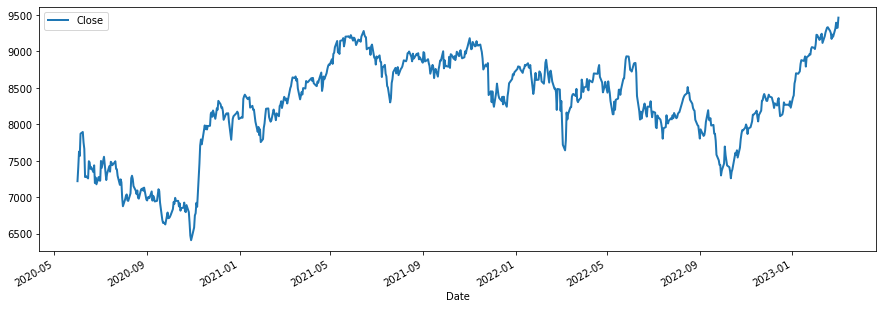

In [32]:
IBEX_values[['Close']].plot(lw=2);

### Rolling average
We shall now create a rolling average, with a window size of 10, using pandas.DataFrame.rolling

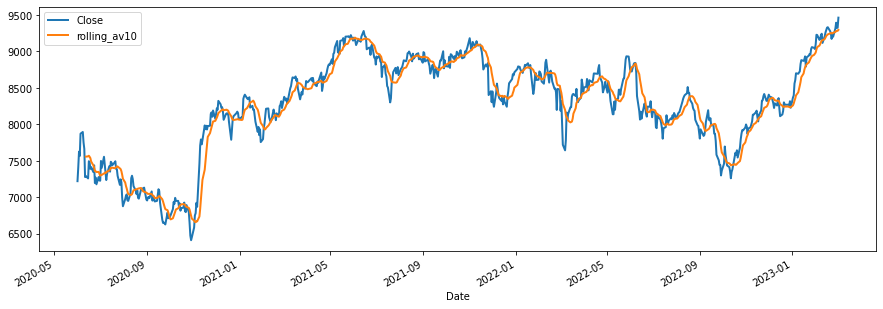

In [37]:
IBEX_values['rolling_av10'] = IBEX_values['Close'].rolling(10).mean()
# take a look
IBEX_values[['Close','rolling_av10']].plot(lw=2);

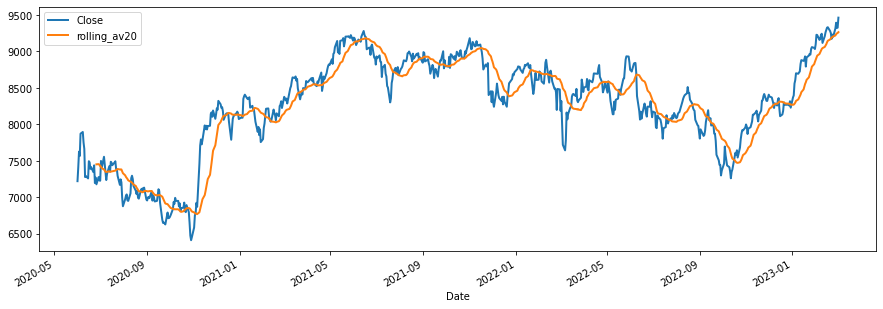

In [38]:
IBEX_values['rolling_av20'] = IBEX_values['Close'].rolling(20).mean()
# take a look
IBEX_values[['Close','rolling_av20']].plot(lw=2);

## Moving average model
To create our moving average model we shall use ARIMA from statsmodels. This is a composite of an autoregressive model, AR( 𝑝
 ), an integration model, I( 𝑑
 ), and a moving average model, MA( 𝑞
 ), which is passed via the tuple order(p,d,q). Here we shall use again a window of  𝑞=10
 :

In [39]:
from statsmodels.tsa.arima.model import ARIMA
ARMA_model = ARIMA(endog=IBEX_values['Close'], order=(0, 0, 10))
results = ARMA_model.fit()
print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  711
Model:                ARIMA(0, 0, 10)   Log Likelihood               -4702.931
Date:                Sat, 04 Mar 2023   AIC                           9429.861
Time:                        05:50:20   BIC                           9484.661
Sample:                             0   HQIC                          9451.029
                                - 711                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8267.5407     55.998    147.639      0.000    8157.786    8377.295
ma.L1          0.5592      0.826      0.677      0.499      -1.060       2.179
ma.L2          0.9293      0.352      2.637      0.0

### Predictions
We shall now look at the predictions made by our moving average model

In [40]:
start_date = '2020-06-12'
end_date   = '2021-06-04'
IBEX_values['forecast'] = results.predict(start=start_date, end=end_date)

In [43]:
IBEX_values[['Close','rolling_av10','forecast']].tail(10)

,Close,rolling_av10,forecast
Date,,,
2023-02-20 00:00:00+01:00,9281.299805,9247.050000,NaN
2023-02-21 00:00:00+01:00,9252.099609,9255.019922,NaN
2023-02-22 00:00:00+01:00,9172.700195,9249.559961,NaN
2023-02-23 00:00:00+01:00,9231.599609,9248.369922,NaN
2023-02-24 00:00:00+01:00,9201.500000,9256.779883,NaN
2023-02-27 00:00:00+01:00,9314.299805,9267.179883,NaN
2023-02-28 00:00:00+01:00,9394.599609,9280.319824,NaN
2023-03-01 00:00:00+01:00,9322.900391,9283.129883,NaN
2023-03-02 00:00:00+01:00,9327.299805,9283.129883,NaN


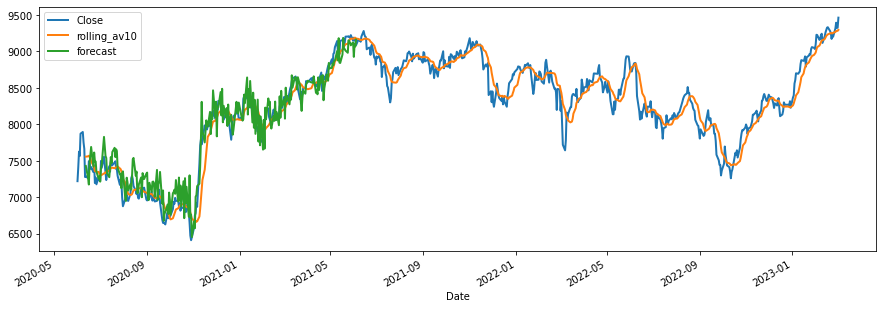

In [44]:
IBEX_values[['Close','rolling_av10','forecast']].plot(lw=2);

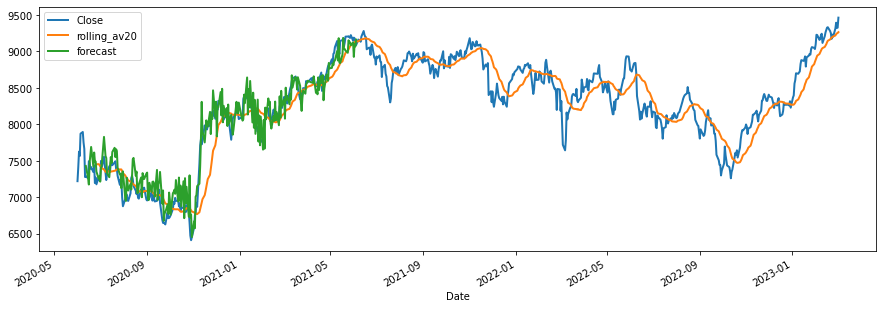

In [45]:
IBEX_values[['Close','rolling_av20','forecast']].plot(lw=2);

# Causal Forests Double ML example using EconML

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from itertools import product
np.random.seed(10)

In [46]:
# install EconML
!pip install -q econml
import econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.1/571.1 KB 47.9 MB/s eta 0:00:00


Two examples
The synthetic dataset
We create a synthetic dataset consisting of 30 features with 10k rows of data. The synthetic data follows the the partially linear regression (PLR) model where we have the outcome given by
`Y = Tθ + g( X ) + ϵ`

  is the causal, or 'lift' parameter that we are interested in calculating. Also we have
            `T = m( X ) + ϵ`

  are the nuisance functions. The first equation is the main equation, whilst the second equation is dedicated to the confounding and is analogous to the omitted-variable bias.
In the synthetic data
- Y is the target
- T is the feature of interest
- X are the control vectors  
- W is a matrix of the confounders

In [48]:
def make_dataset():
    N_features   =    30
    N_rows       = 10000

    # create the irreducible error component
    random_noise = lambda N_rows: np.random.uniform(-1, 1, size = N_rows)
    
    # create the control
    X  = np.random.uniform(0, 1, size=(N_rows,1))
    
    # create the true treatment effect data
    TE = np.array([true_relationship(x_i) for x_i in X])

    # create the functions mapping the support of X to ℝ
    support_size = 5
    support = np.random.choice(np.arange(N_features), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    coefs_T = np.random.uniform(0, 1, size=support_size)

    # create the confounders
    W =          np.random.normal( 0, 1, size=(N_rows, N_features))
    # create the treatment feature within W
    T =          np.dot( W[:, support], coefs_T) + random_noise(N_rows)
    # create the outcome (target)
    Y = (TE*T) + np.dot( W[:, support], coefs_Y) + random_noise(N_rows)
    
    return (Y, T, X, W)

Example 1.
The ground truth relationship between the treatment feature and the outcome is given by     `θ(x) = e2x`

In [49]:
# Treatment effect function
def true_relationship(x):
    return np.exp(2*x[0])

Y, T, X, W = make_dataset()

In [53]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor

non_parametric_model = CausalForestDML(model_y= RandomForestRegressor(random_state=0),
                                       model_t= RandomForestRegressor(random_state=0),
                                       criterion='mse', n_estimators=1000,
                                       min_impurity_decrease=0.001,random_state=0)

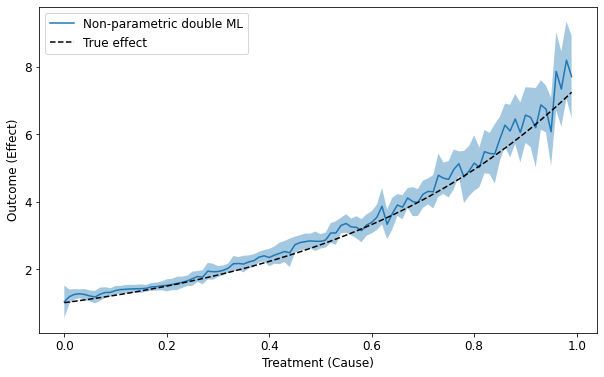

In [54]:
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=1)))

non_parametric_model.fit(Y, T, X=X, W=W);
non_parametric_model_results = non_parametric_model.effect(X_test)
lb, ub                       = non_parametric_model.effect_interval(X_test, alpha=0.01)

# plot the reults
plt.figure(figsize=(10,6))
# double ML results plot
plt.plot(X_test, non_parametric_model_results, label='Non-parametric double ML')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4)
# ground truth plot
ground_truth = np.array([true_relationship(x_i) for x_i in X_test])
plt.plot(X_test, ground_truth, '--', label='True effect', c='black')
plt.ylabel('Outcome (Effect)')
plt.xlabel('Treatment (Cause)')
plt.legend(loc='upper left')
plt.show();

## Example 2.
The ground truth relationship between the treatment feature and the outcome is given by     `θ(x) = sin(πx)`

In [55]:
# Treatment effect function
def true_relationship(x):
    return np.sin(np.pi*x[0])

Y, T, X, W = make_dataset()

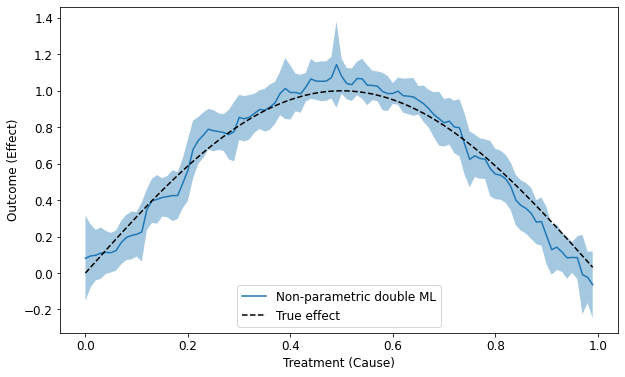

In [56]:
non_parametric_model.fit(Y, T, X=X, W=W);
non_parametric_model_results = non_parametric_model.effect(X_test)
lb, ub                       = non_parametric_model.effect_interval(X_test, alpha=0.01)
# plot the reults
plt.figure(figsize=(10,6))
# double ML results plot
plt.plot(X_test, non_parametric_model_results, label='Non-parametric double ML')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4)
# ground truth plot
ground_truth = np.array([true_relationship(x_i) for x_i in X_test])
plt.plot(X_test, ground_truth, '--', label='True effect', c='black')
plt.ylabel('Outcome (Effect)')
plt.xlabel('Treatment (Cause)')
plt.legend(loc='lower center')
plt.show();

As can be seen the results are more than satisfactory.

In a forthcoming notebook I shall apply double ML to some 'real-world' data.

# Stationarity and detrending (ADF/KPSS)

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [58]:
sunspots = sm.datasets.sunspots.load_pandas().data

In [59]:
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
del sunspots["YEAR"]

<AxesSubplot:>

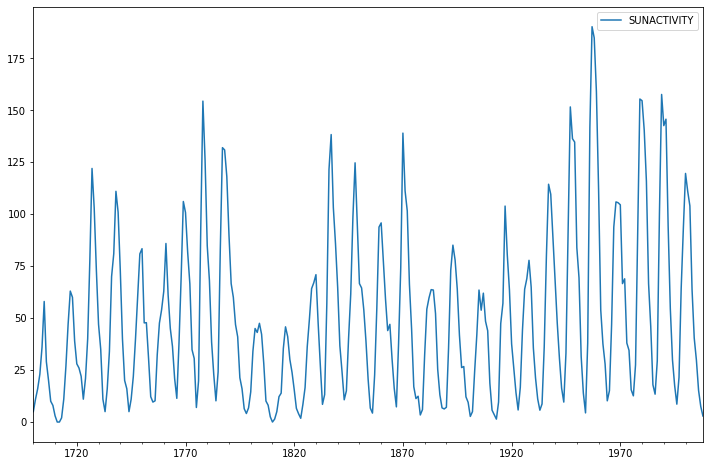

In [60]:
sunspots.plot(figsize=(12, 8))

### ADF test¶
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

A function is created to carry out the ADF test on a time series.

In [61]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

### KPSS test¶
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

A function is created to carry out the KPSS test on a time series.

In [63]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

The ADF tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.

ADF test is now applied on the data.

In [64]:
adf_test(sunspots["SUNACTIVITY"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.837781
p-value                          0.053076
#Lags Used                       8.000000
Number of Observations Used    300.000000
Critical Value (1%)             -3.452337
Critical Value (5%)             -2.871223
Critical Value (10%)            -2.571929
dtype: float64


Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, the series is non-stationary.

The KPSS tests gives the following results – test statistic, p value and the critical value at 1%, 5% , and 10% confidence intervals.

KPSS test is now applied on the data.

In [65]:
kpss_test(sunspots["SUNACTIVITY"])

Results of KPSS Test:
Test Statistic           0.669866
p-value                  0.016285
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

Case 1: Both tests conclude that the series is not stationary - The series is not stationary
Case 2: Both tests conclude that the series is stationary - The series is stationary
Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting.



### Detrending by Differencing¶
It is one of the simplest methods for detrending a time series. A new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

Differencing is applied on the data and the result is plotted.

<AxesSubplot:>

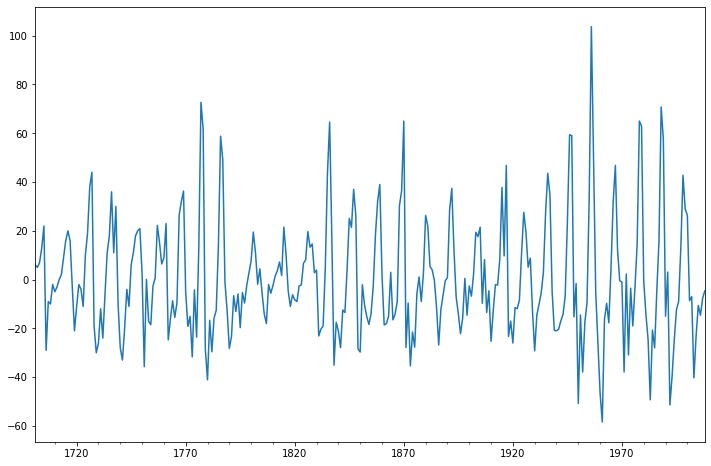

In [66]:
sunspots["SUNACTIVITY_diff"] = sunspots["SUNACTIVITY"] - sunspots["SUNACTIVITY"].shift(1)
sunspots["SUNACTIVITY_diff"].dropna().plot(figsize=(12, 8))

ADF test is now applied on these detrended values and stationarity is checked.

In [67]:
adf_test(sunspots["SUNACTIVITY_diff"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.486166e+01
p-value                        1.715552e-27
#Lags Used                     7.000000e+00
Number of Observations Used    3.000000e+02
Critical Value (1%)           -3.452337e+00
Critical Value (5%)           -2.871223e+00
Critical Value (10%)          -2.571929e+00
dtype: float64


Based upon the p-value of ADF test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is strict stationary now.

KPSS test is now applied on these detrended values and stationarity is checked.

In [68]:
kpss_test(sunspots["SUNACTIVITY_diff"].dropna())

Results of KPSS Test:
Test Statistic           0.021193
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



Based upon the p-value of KPSS test, the null hypothesis can not be rejected. Hence, the series is stationary.

#### Conclusion¶
Two tests for checking the stationarity of a time series are used, namely ADF test and KPSS test. Detrending is carried out by using differencing. Trend stationary time series is converted into strict stationary time series. Requisite forecasting model can now be applied on a stationary time series data.